In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import QuantileTransformer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

In [2]:
with open('../data/05_model_input/cv_splits_dict.pkl/2020-08-28T04.48.19.250Z/cv_splits_dict.pkl', 'rb') as pkl_file:
    cv_splits_dict = pickle.load(pkl_file)
    
df_spatiotemporal = capacity_factors_daily_2000to2015 = pd.read_hdf(
    path_or_buf='../data/05_model_input/df_spatiotemporal.hdf', 
    key='df_spatiotemporal'
)

In [3]:
df_spatiotemporal['temporal'].columns.get_level_values('district')

Index(['DE111', 'DE114', 'DE115', 'DE116', 'DE118', 'DE119', 'DE11A', 'DE11B',
       'DE11C', 'DE11D',
       ...
       'DEG0E', 'DEG0F', 'DEG0G', 'DEG0I', 'DEG0J', 'DEG0K', 'DEG0L', 'DEG0M',
       'DEG0N', 'DEG0P'],
      dtype='object', name='district', length=292)

In [4]:
df_spatiotemporal['temporal']['DEF0C']

var,power
2013-01-01,0.298824
2013-01-02,0.277085
2013-01-03,0.561925
2013-01-04,0.603515
2013-01-05,0.139887
...,...
2015-12-27,0.652169
2015-12-28,0.313875
2015-12-29,0.591666
2015-12-30,0.460236


In [5]:
def _split_train_test(df, cv_splits_dict, pass_id: str):
    train_idx_start = cv_splits_dict[pass_id]['train_idx'][0]
    train_idx_end = cv_splits_dict[pass_id]['train_idx'][1]

    test_idx_start = cv_splits_dict[pass_id]['test_idx'][0]
    test_idx_end = cv_splits_dict[pass_id]['test_idx'][1]

    return {
        'train': df.iloc[train_idx_start:train_idx_end, :],
        'test': df.iloc[test_idx_start:test_idx_end, :],
    }

In [99]:
DISTRICTS_OF_INTEREST = ['DEF0C', 'DE111']

def _get_last_train_idx(tss: pd.DataFrame, cv_splits_dict: dict):  
    longest_pass = list( cv_splits_dict.keys() )[-1]
    y = _split_train_test(tss, cv_splits_dict, pass_id=longest_pass)
    return y['train'].index[-1]

def scale_offset_timeseries(df_temporal: pd.DataFrame, cv_splits_dict: dict, level_offset: int):
    quantile_transformer = QuantileTransformer(
        output_distribution='normal', 
        random_state=0
    )
    
    tss = df_temporal
    
    last_train_idx = _get_last_train_idx(tss, cv_splits_dict)
    quantile_transformer.fit( 
        tss.loc[:last_train_idx, 
                DISTRICTS_OF_INTEREST
               ]
    )

    tss_scaled = pd.DataFrame(
        index = df_temporal.index,
        columns = DISTRICTS_OF_INTEREST,
        data = quantile_transformer.transform( tss[DISTRICTS_OF_INTEREST] ) + level_offset
    )
    
    return tss_scaled

tss_scaled = scale_offset_timeseries(df_temporal=df_spatiotemporal['temporal'], cv_splits_dict=cv_splits_dict, level_offset=10)

tss_scaled.head()

,DEF0C,DE111
2013-01-01,10.403652,11.532445
2013-01-02,10.326991,10.086973
2013-01-03,11.280925,10.326991
2013-01-04,11.417915,11.214852
2013-01-05,9.693305,11.197728


<AxesSubplot:ylabel='Density'>

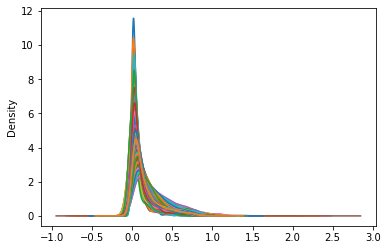

In [100]:
tss[['DEF0C', 'DE111']].plot.density(legend=False)

<AxesSubplot:ylabel='Density'>

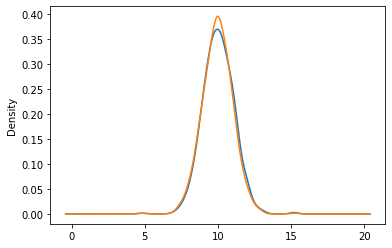

In [87]:
tss_scaled.plot.density(legend=False)

In [53]:
model = {}
for pass_id in cv_splits_dict.keys():  
    
    model[pass_id] = {}
        
    # splitting
    y = _split_train_test(tss_scaled, cv_splits_dict, pass_id)
    
    # training
    for district in tss_scaled.columns:        
        model[pass_id][district] = ExponentialSmoothing(
            y['train'][district], 
            trend='add',
            seasonal='mul',
            seasonal_periods=365,
        ).fit()

/home/jonasmmiguel/Documents/learning/poli/thesis/wind-stf/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/home/jonasmmiguel/Documents/learning/poli/thesis/wind-stf/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/home/jonasmmiguel/Documents/learning/poli/thesis/wind-stf/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/home/jonasmmiguel/Documents/learning/poli/thesis/wind-stf/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimi

In [54]:
# test_idx = y['test'].index
test_idx = y['train'].index


pred_scaled = {}
pred = {}

for pass_id in cv_splits_dict.keys():  
        
    pred_scaled[pass_id] = {}
    
    for district in tss_scaled.columns:
        # prediction
        pred_scaled[pass_id][district] = model[pass_id][district].predict(
            start=test_idx[0],
            end=test_idx[-1]
        )
    
    # postprocessing prediction
    pred[pass_id] = pd.DataFrame(
        data =  quantile_transformer.inverse_transform(
            pd.DataFrame( pred_scaled[pass_id] ) - 10
        ),
        columns = tss_scaled.columns,
        index = test_idx,
    )

In [55]:
quantile_transformer.inverse_transform( pd.DataFrame( pred_scaled[pass_id] ) - 10 )

array([[0.32317766, 0.04884741],
       [0.48217018, 0.18163839],
       [0.33439324, 0.09422306],
       ...,
       [0.06238127, 0.00912165],
       [0.10613881, 0.0138957 ],
       [0.09994843, 0.03112139]])

In [45]:
pred['pass_3']

,DEF0C,DE111
2013-01-01,0.323178,0.048847
2013-01-02,0.482170,0.181638
2013-01-03,0.334393,0.094223
2013-01-04,0.340167,0.047098
2013-01-05,0.190922,0.045993
...,...,...
2015-06-25,0.084333,0.017745
2015-06-26,0.046877,0.003834
2015-06-27,0.062381,0.009122
2015-06-28,0.106139,0.013896


In [62]:
tss.loc[ pred['pass_3'].index, pred['pass_3'].columns ]

district,DEF0C,DE111
var,power,power
2013-01-01,0.298824,0.178783
2013-01-02,0.277085,0.030363
2013-01-03,0.561925,0.041567
2013-01-04,0.603515,0.128148
2013-01-05,0.139887,0.126854
...,...,...
2015-06-25,0.043115,0.004975
2015-06-26,0.011318,0.004748
2015-06-27,0.215408,0.044574


In [ ]:
y['test']['DEF0C']

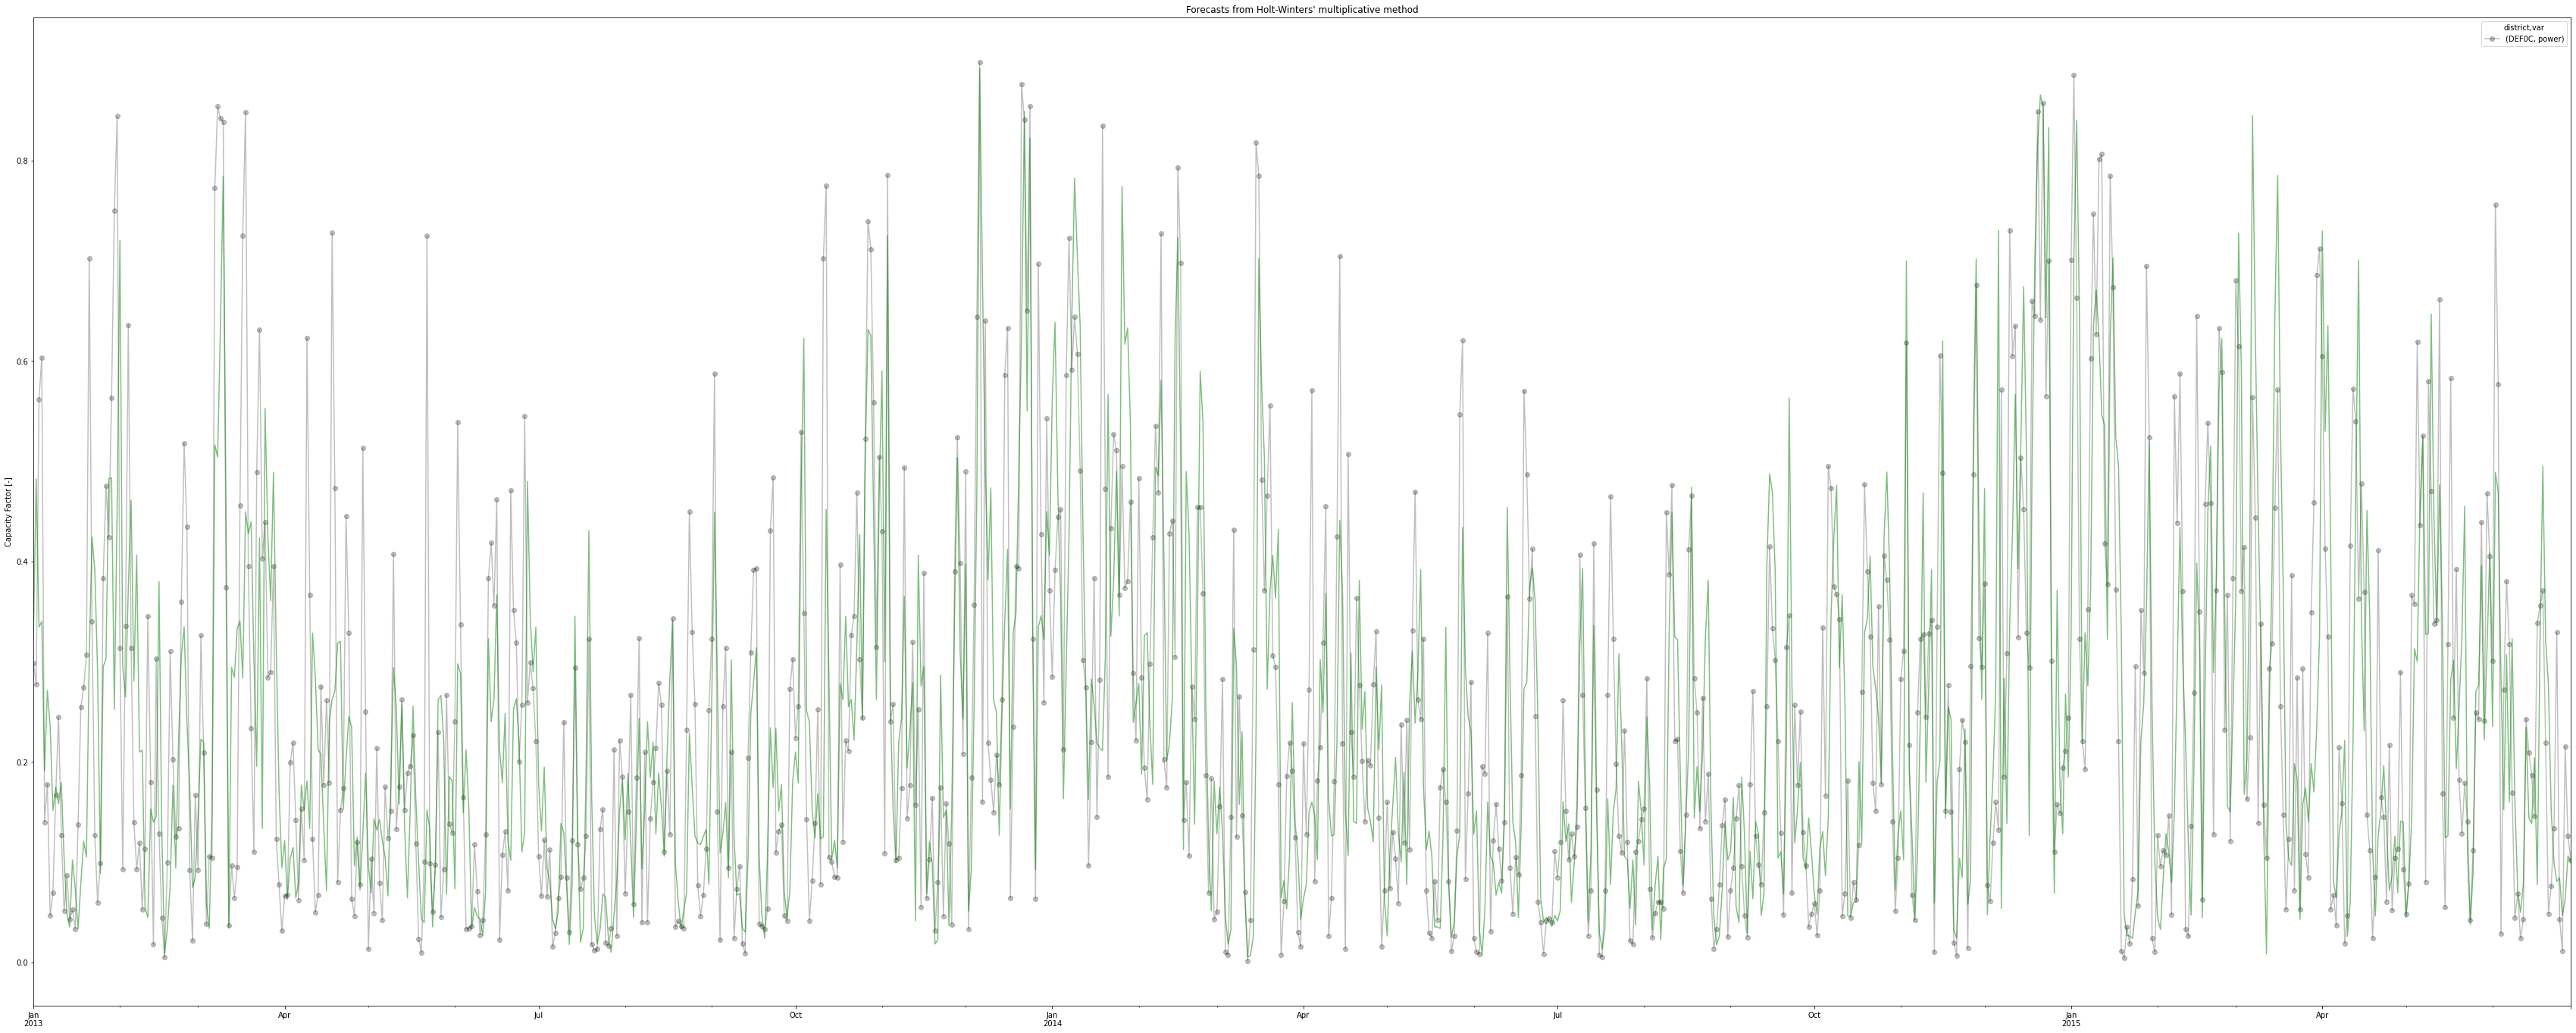

In [102]:
ax = tss.loc[ pred['pass_3'].index, ['DEF0C'] ].plot(figsize=(60,24), color='black',marker='o', alpha=0.25, title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Capacity Factor [-]")
pred['pass_3']['DEF0C'].plot(ax=ax, style='-', color='green', alpha=0.5)
plt.show()

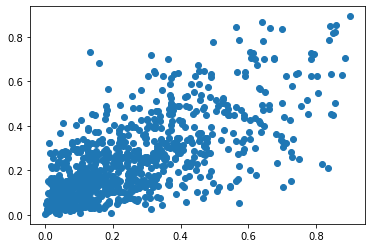

In [68]:
plt.scatter(x=tss.loc[ pred['pass_3'].index, ['DEF0C'] ], y=pred['pass_3']['DEF0C'])

<AxesSubplot:ylabel='Density'>

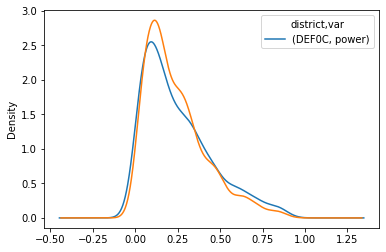

In [70]:
ax = tss.loc[ pred['pass_3'].index, ['DEF0C'] ].plot.density()
pred['pass_3']['DEF0C'].plot.density()